In [2]:
import pickle
import numpy as np
import pandas as pd
import os, glob
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## The following are the ML models which can be used for trasinning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler,StandardScaler

import timeit
import warnings
warnings.filterwarnings("ignore")


E:\Anaconda3\envs\tf\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
%matplotlib inline
import pandas as pd

In [4]:
import seaborn as sns
sns.set(style="darkgrid")

In [5]:
sns.set_context('talk')

In [6]:
from IPython.display import display, HTML, Image

In [7]:
import matplotlib.colors as mcolors

In [8]:
dataFolder = os.getcwd()
modelParentFolder = os.path.dirname(dataFolder)

In [9]:
group1_low =1.634
group2_low =0.673
group2_upper =1.634
group3_upper =0.673

In [10]:
## read the test file
data =pd.read_csv(os.path.join(dataFolder,'dataset5K_train.csv'))
data.columns =[col.strip() for col in data.columns]
data['ratio'] = data['b(CaO)']/data['b(SiO2)']
group1 = data[data['ratio']>=group1_low]  # with Portlandite, no Amor-S1
group2 = data[(data['ratio']<=group2_upper) & (data['ratio']>=group2_low)]  # no Portlandite, no Amor-S1
group3 = data[data['ratio']<=group3_upper]     # no Portlandite, with Amor-S1
groups = [group1,group2,group3]
dataCols = data.columns

In [11]:
modelSummary={'rfModel':'ModelTrainSummary_rfModel.csv',
              'lgbModel':'ModelTrainSummary_lgBoost.csv',
              'gbModel':'ModelTrainSummary_gBoost.csv',
              'GPyModel':'ModelTrainSummary_GPy.csv'
}

In [12]:
## read trained Model info:
def getReadyModelInfo(dataFolder,fileNameModelSummary,dataCols):
    
    modelInfo =pd.read_csv(os.path.join(dataFolder,fileNameModelSummary))
    
    modelInfo = modelInfo.iloc[:,1:4]
    ## load the mdoels
    dataCols = data.columns.to_list()
    modelsLst = []
    for irow,row in modelInfo.iterrows():
        group = row['group']
        var =row['var']
        modelType = row['modelType']
        icol =dataCols.index(var)
        if '/' in var:
            fileCol = var.replace("/",'')
        else:
            fileCol = var            
    
        modelFolder = os.path.join(dataFolder,'SavedModel',group)
        if modelType=='CONST':
            ext = '.csv'
            fileName = os.path.join(modelFolder,modelType + '_'+str(icol)+'_'+fileCol+ext)
            tempModel =pd.read_csv(fileName)
        else:
            ext ='.sav'
            fileName = os.path.join(modelFolder,modelType + '_'+str(icol)+'_'+fileCol+ext)
            tempModel = pickle.load(open(fileName, 'rb'))
        
        modelsLst.append(tempModel)
    
    modelInfo['modelObj'] = modelsLst 
    
    return modelInfo

In [14]:
finalDF = pd.DataFrame()
for ML,modelSummaryCsv in modelSummary.items():
    tempModelInfo = getReadyModelInfo(modelParentFolder,modelSummaryCsv,dataCols)
    for col in group1.columns[4:-1]:  # exclude 'ratio' 
        colModelInfo = tempModelInfo[tempModelInfo['var'] == col]  
        
        for i, group in enumerate(groups):
        
            dataX = group.iloc[:,1:4]    
            dataY = group[col].values
            groupModelInfo = colModelInfo[colModelInfo['group'] =='group'+str(i+1)]
            modelType = groupModelInfo['modelType'].values[0]
            model = groupModelInfo['modelObj'].values[0]
            if modelType=='CONST':
                y_pred = list(model['const'].values)*len(dataY)
                
            elif modelType=='linear':
                y_pred = model.predict(dataX.values)
            
            else:
                scaler = StandardScaler().fit(dataX.values)
                X_scaled = scaler.transform(dataX.values)  # This will be used for input of trainning dataset
                y_pred  = model.predict(X_scaled)  
    
            tempDF = pd.DataFrame({'testDataY':dataY, 'predDataY':y_pred})
            tempDF['modelType'] = [modelType]*len(tempDF)
            tempDF['var'] = [col]*len(tempDF)
            tempDF['group'] = ['group'+str(i+1)]*len(tempDF)
            tempDF['modelSimulation'] = [ML+'_simulation']*len(tempDF)
                
            if len(finalDF)==0:   
                finalDF = tempDF
            else:
                finalDF = pd.concat([finalDF,tempDF],axis=0)
    

In [18]:
finalDF.to_csv('Comparison_predict_5KDataset.csv',index=False)

# Visualization of the prediction of the test dataset

In [19]:
def drawPlots(trgVar,testDataY,predDataY,simulation):
    
    fig, ax =plt.subplots(figsize=(8,8))
    
    RMSE = mean_squared_error(testDataY,predDataY)
    R2   = r2_score(testDataY,predDataY)
    axMax = max(max(testDataY),max(predDataY))
    axMin = min(min(testDataY),min(predDataY))
    
    ## Fitting the line           
    x2= np.linspace(axMin,axMax,30);
    y2 = x2
    ax.plot(testDataY,predDataY,'bo',markerfacecolor = 'blue',markeredgecolor ='darkblue',markeredgewidth=0.5,label=trgVar)
    
    #ax.plot(df3['b(SiO2)'].values,df3['b(CaO)'].values,'bo',markerfacecolor = 'c',markeredgecolor ='b',markeredgewidth=0.5,label='no Amor-S1')
    #ax.plot(group3['b(SiO2)'].values,group3['b(CaO)'].values,'g^',markerfacecolor = 'm',markeredgecolor ='m',markeredgewidth=1,label='group3')
    ax.plot(x2,y2,'r-',lw=3,label ='1:1 ratio')
    ax.legend (loc='best',ncol=5)           
    ax.set_xlim(axMin,axMax)
    ax.set_ylim(axMin,axMax)
    #ax.text(0.05, 0.8, 'Above the line with Portlandite',fontsize = 20,color = 'k')
    #ax.text(0.4, 0.50, 'Below the line no Portlandite',fontsize = 20,color = 'k')
    ax.set_title(simulation+ ' ====> '+trgVar)
    ax.set_xlabel('testDataY')
    ax.set_ylabel('PredDataY')    
        
    return R2, RMSE    

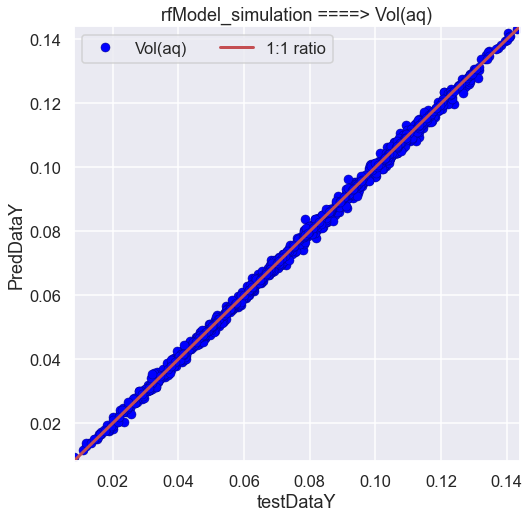

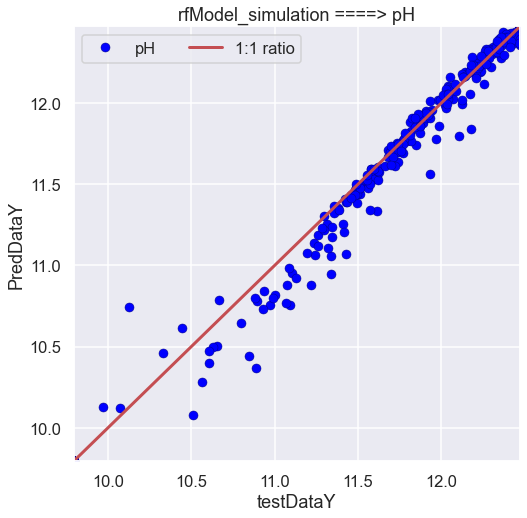

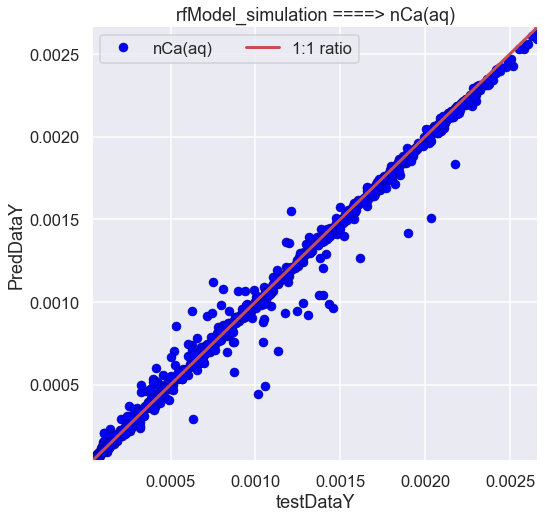

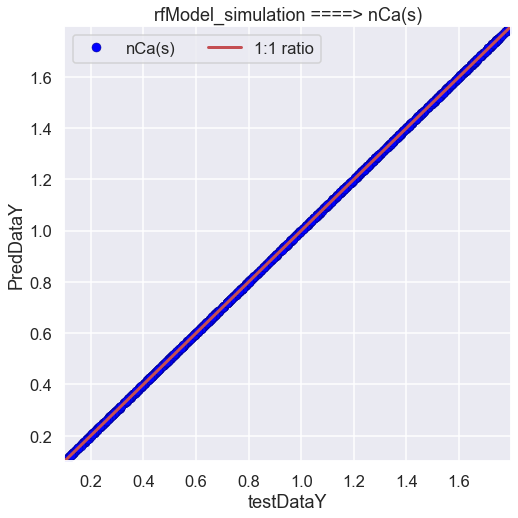

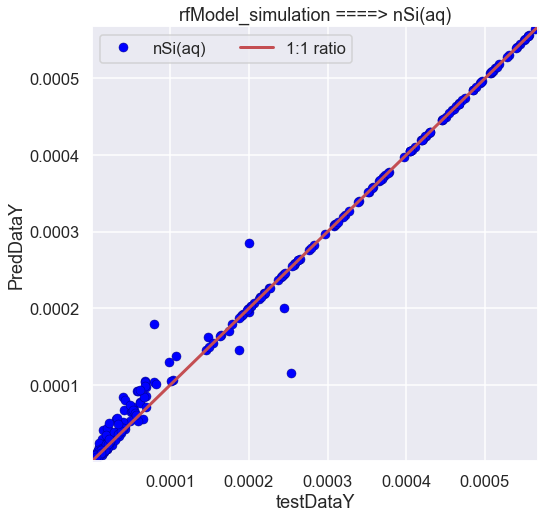

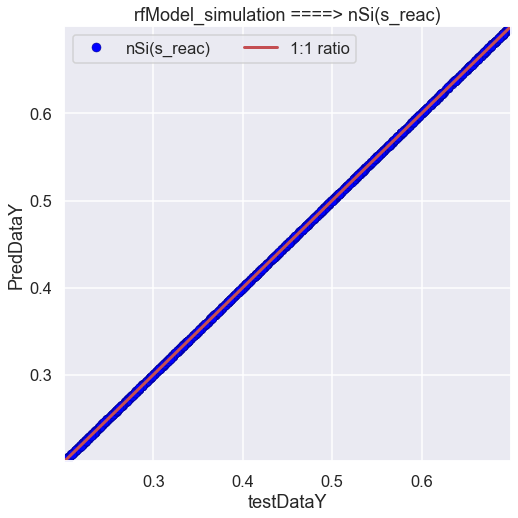

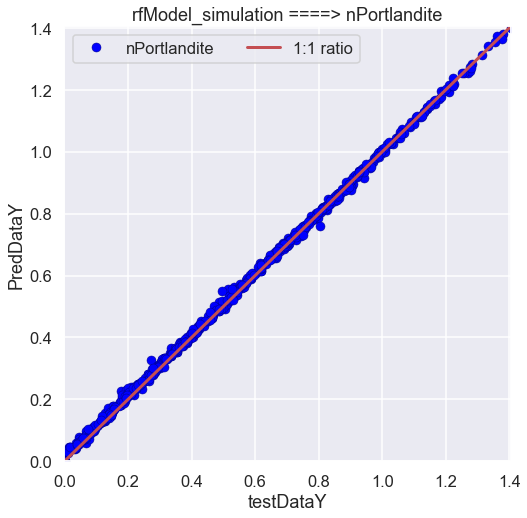

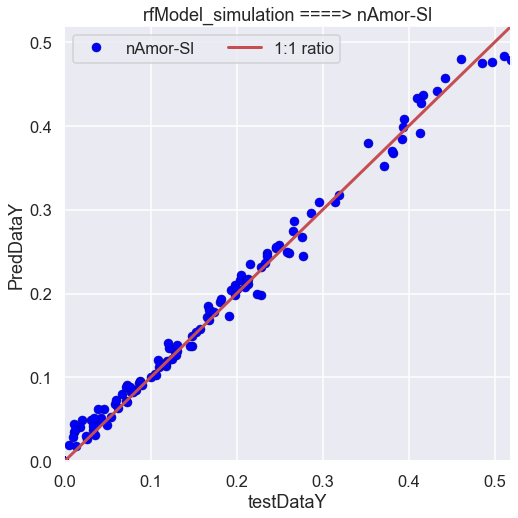

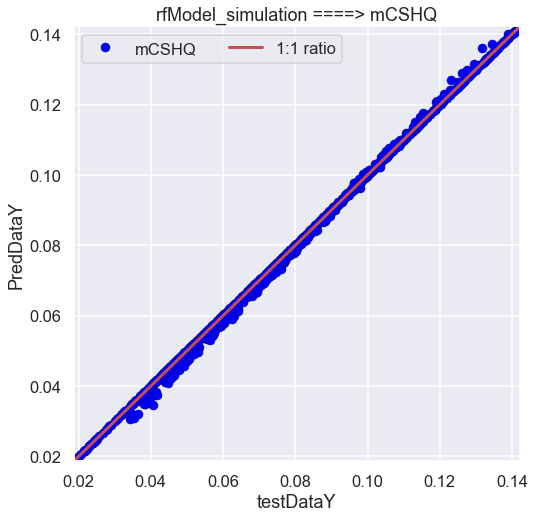

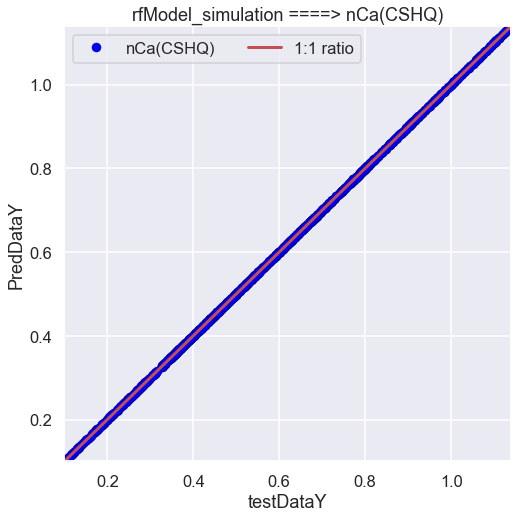

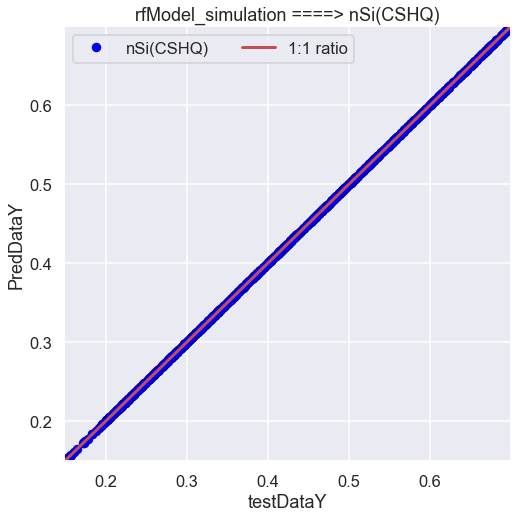

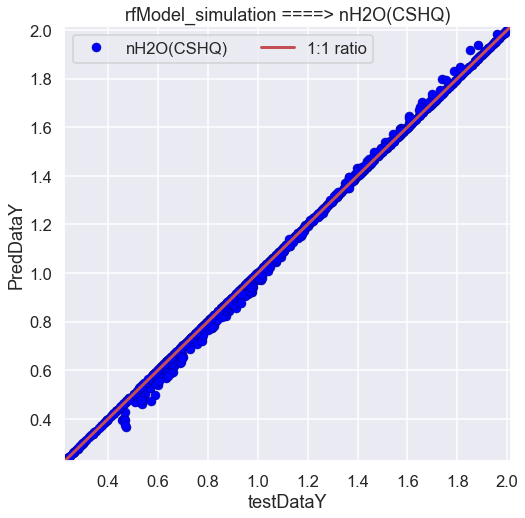

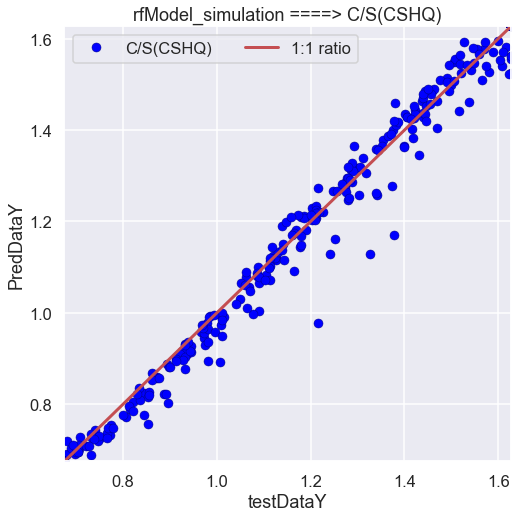

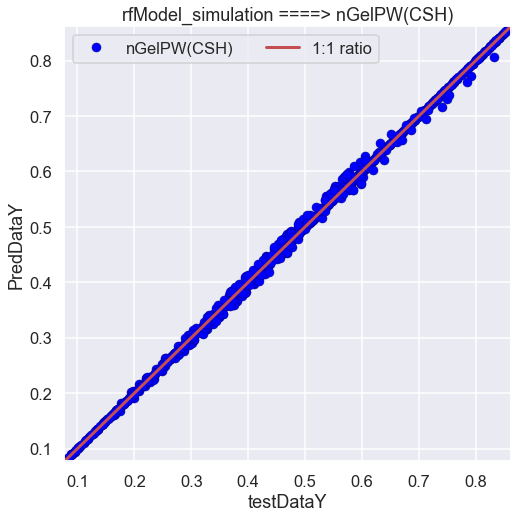

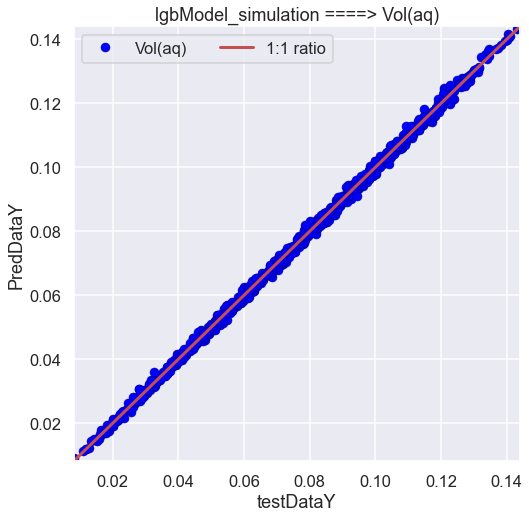

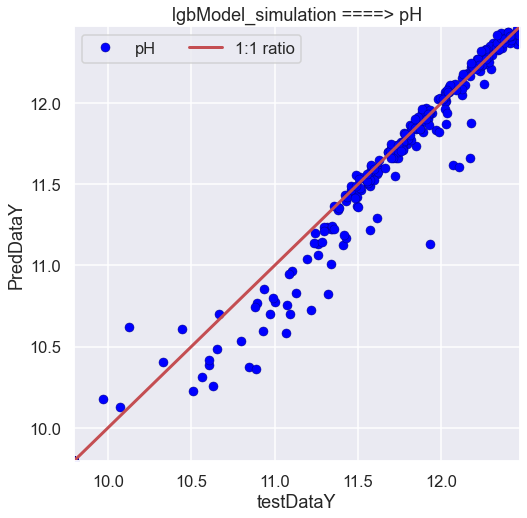

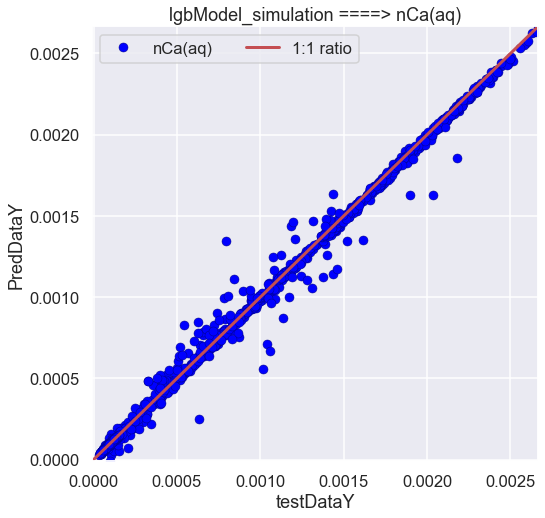

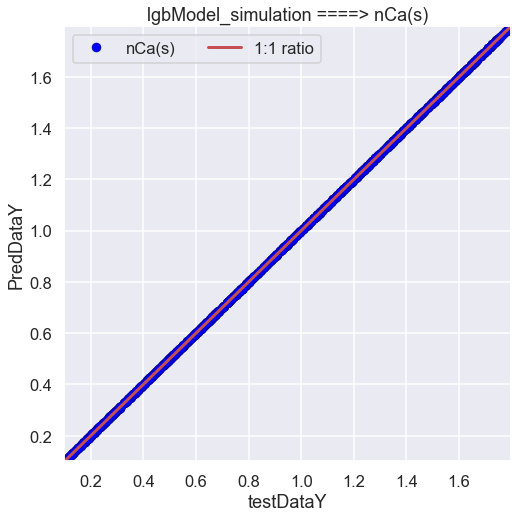

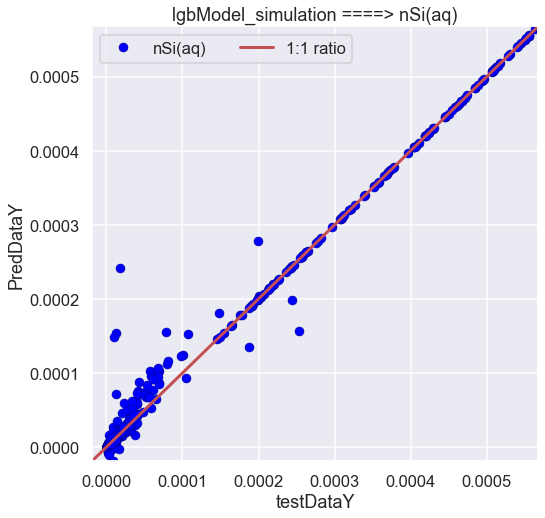

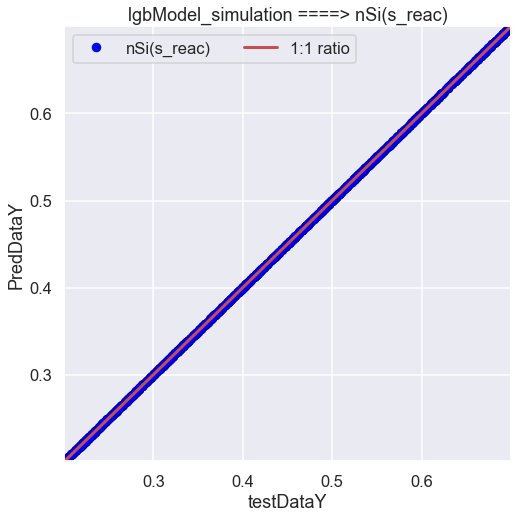

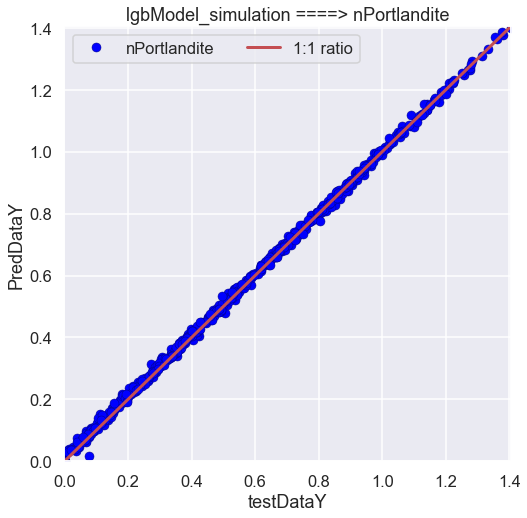

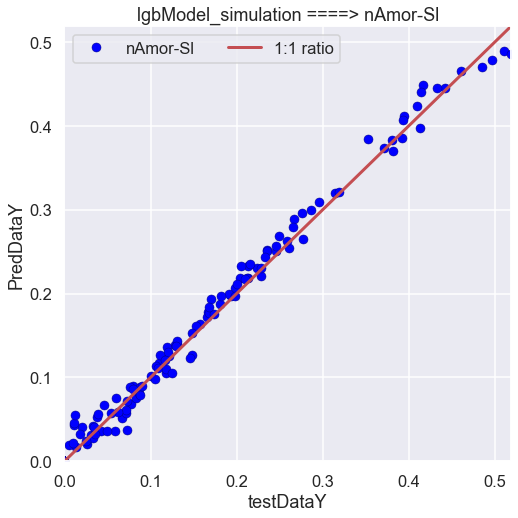

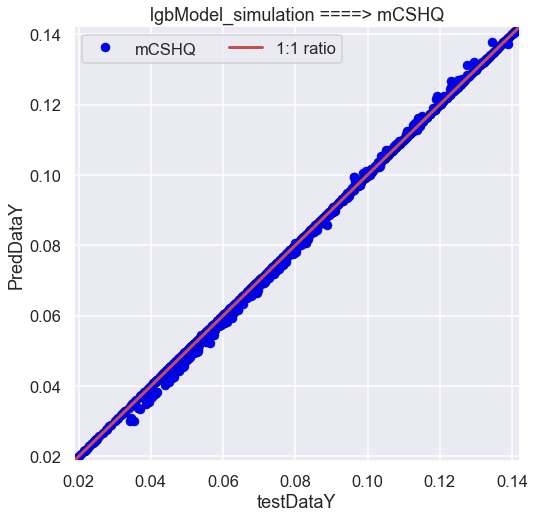

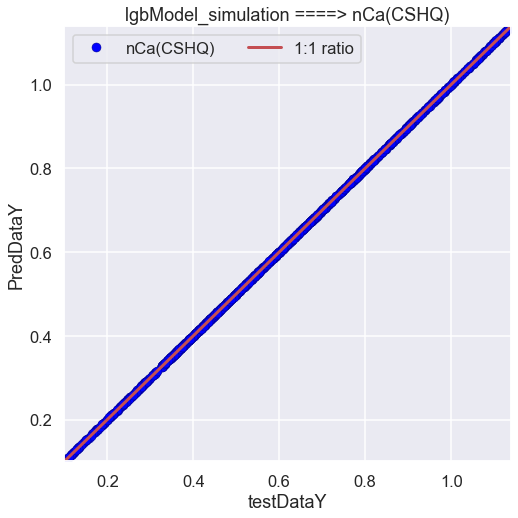

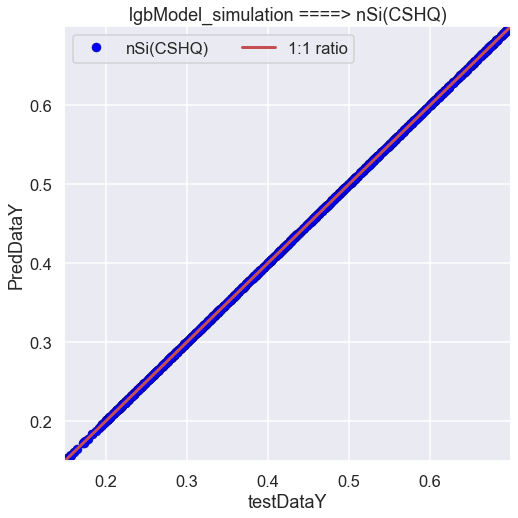

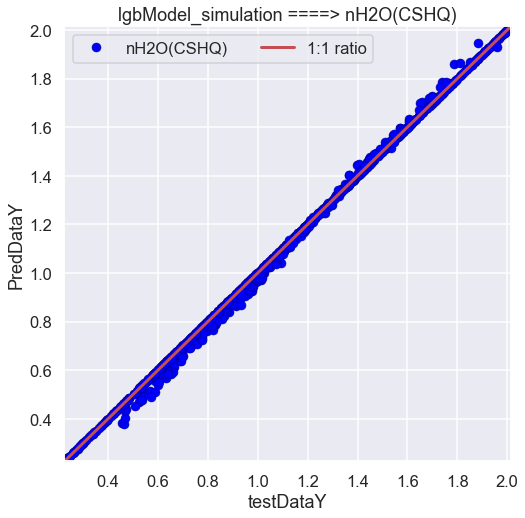

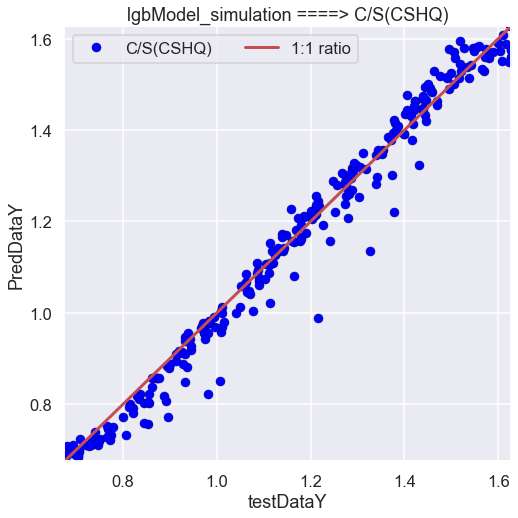

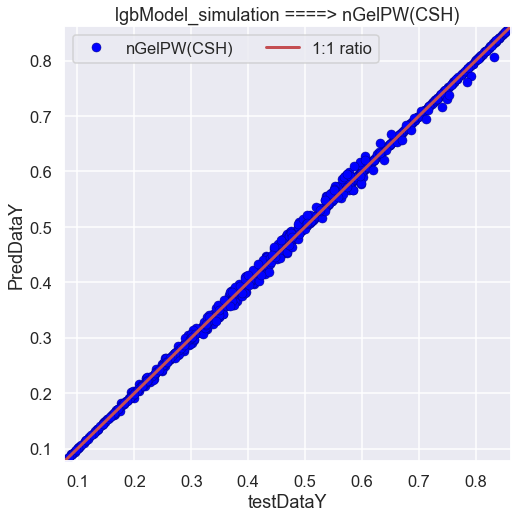

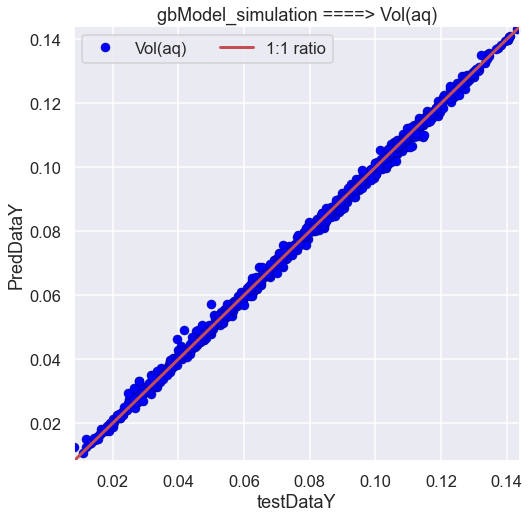

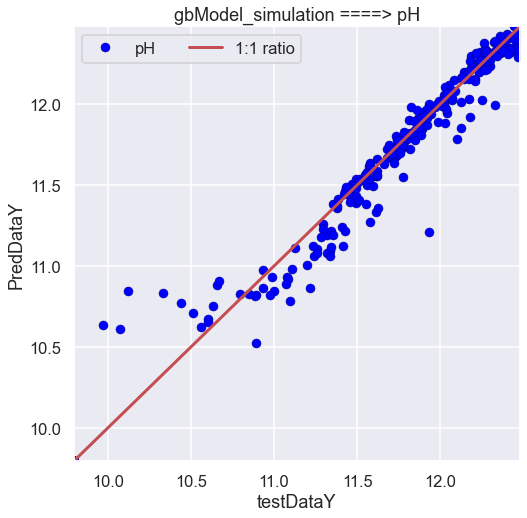

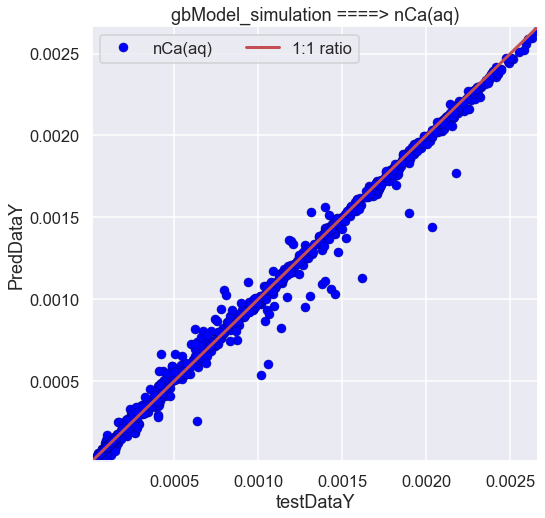

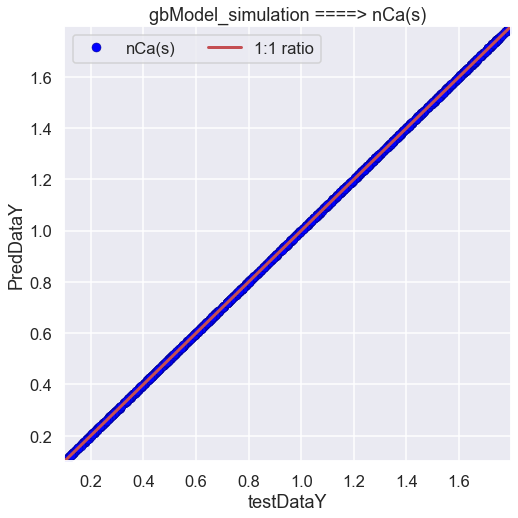

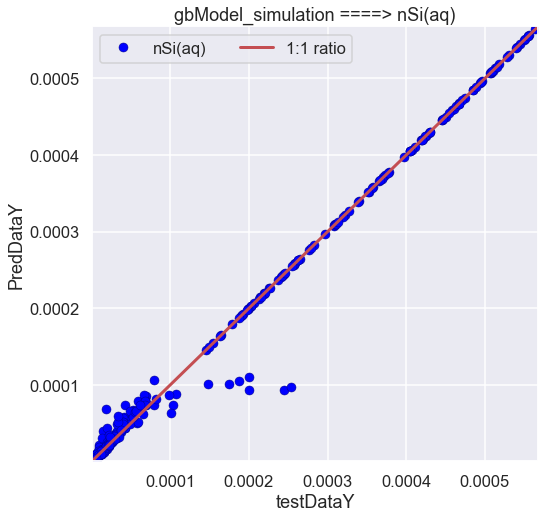

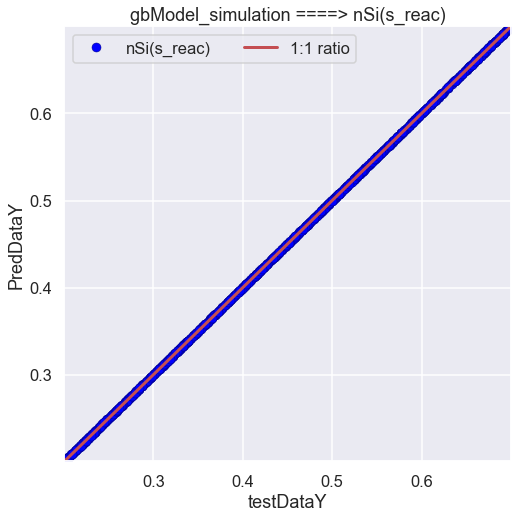

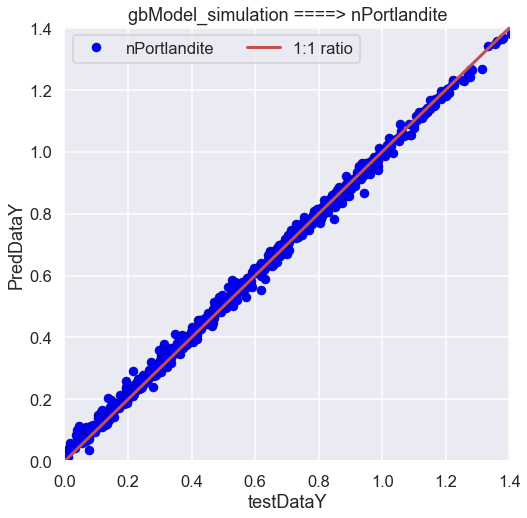

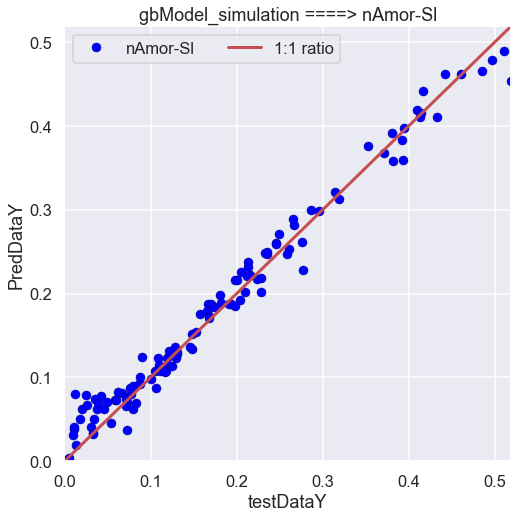

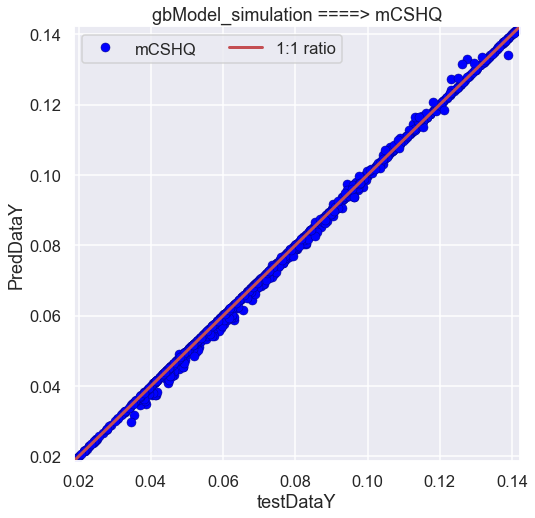

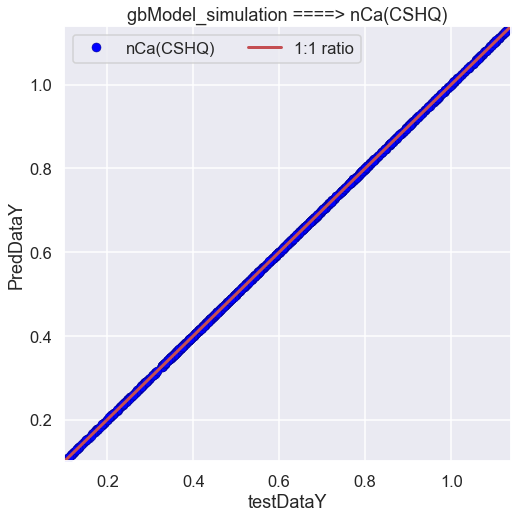

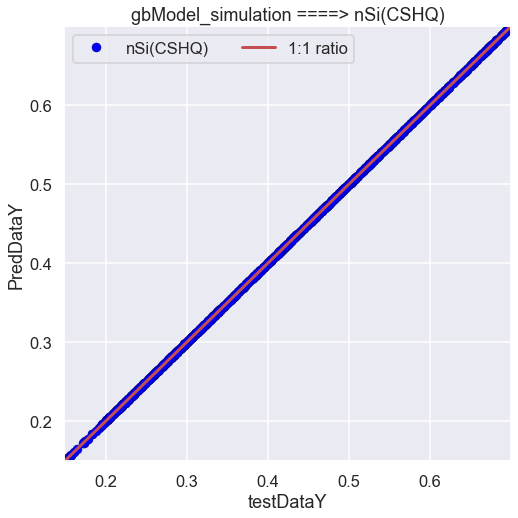

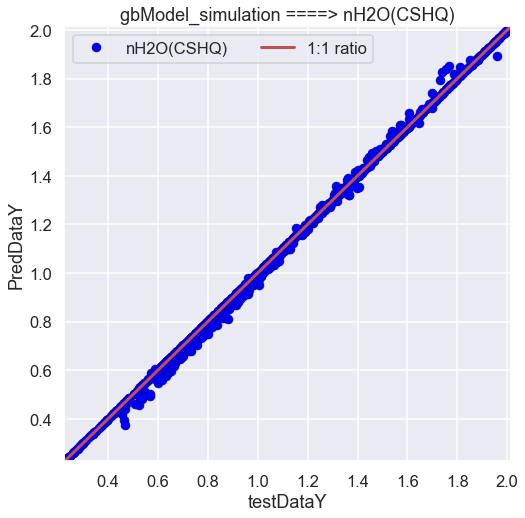

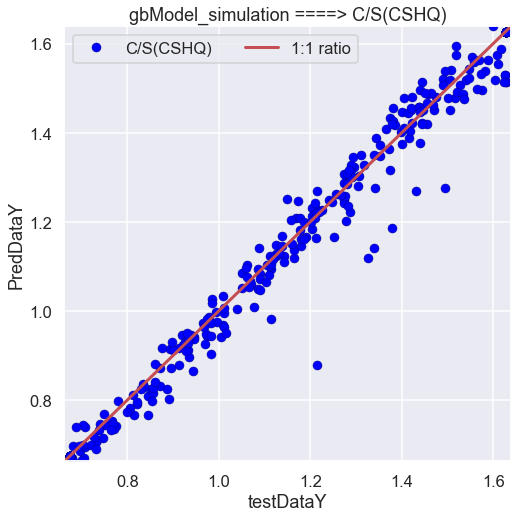

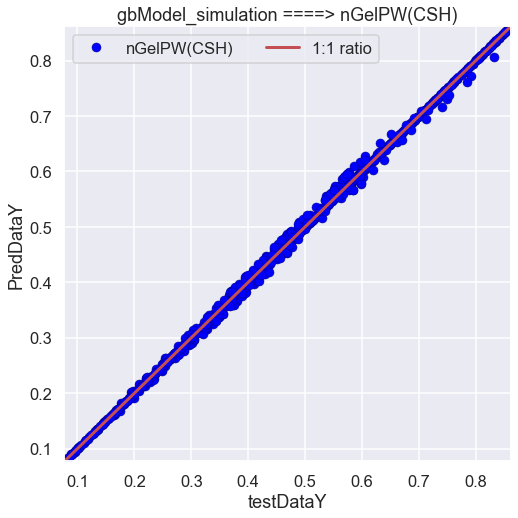

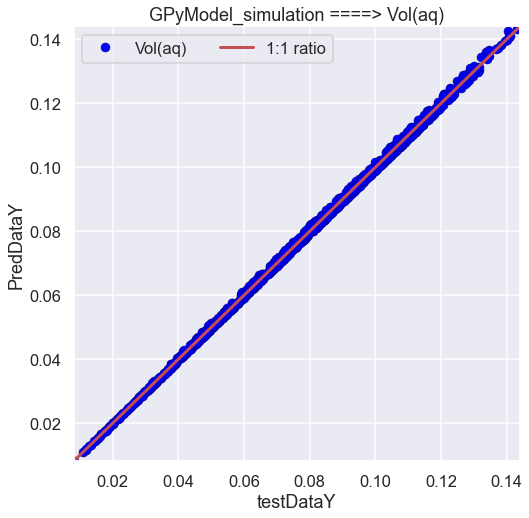

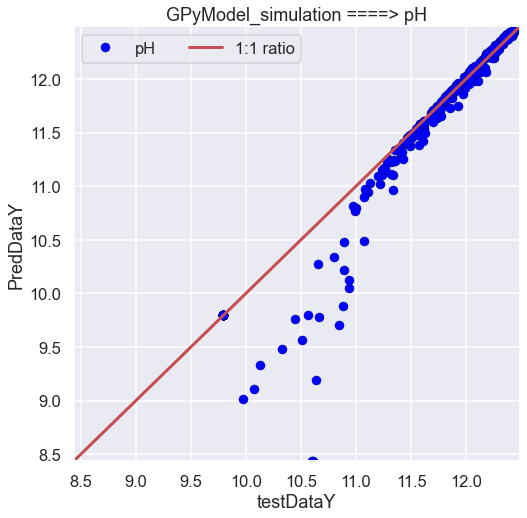

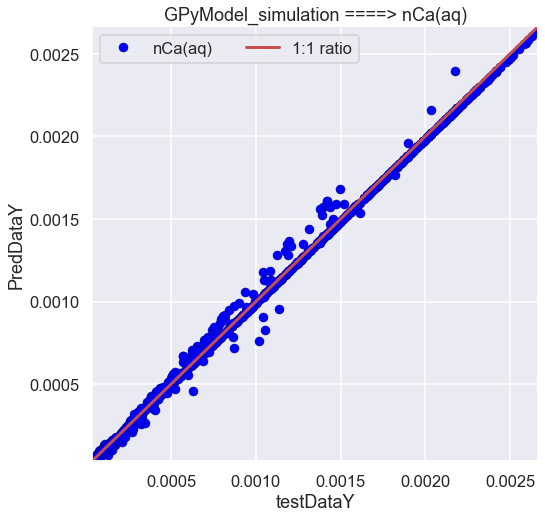

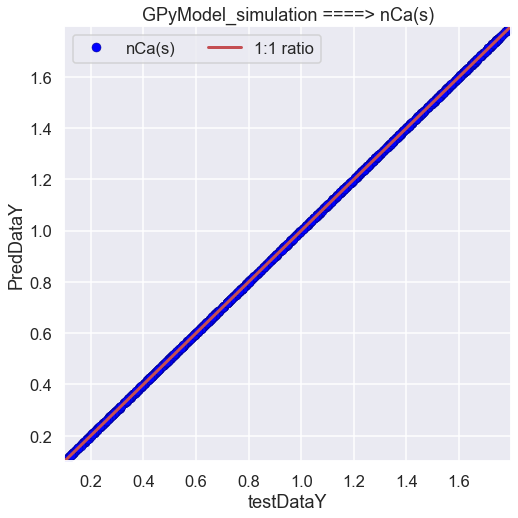

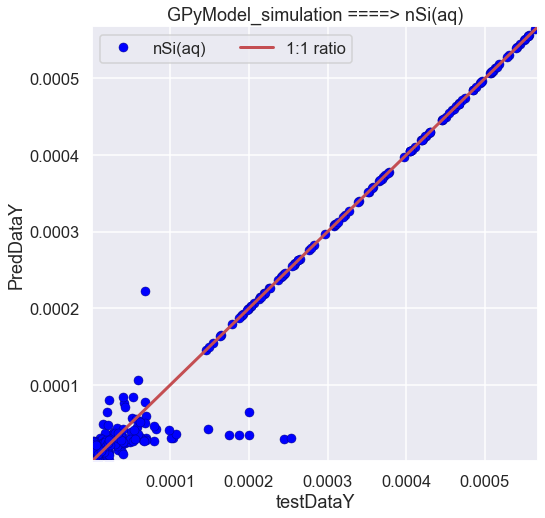

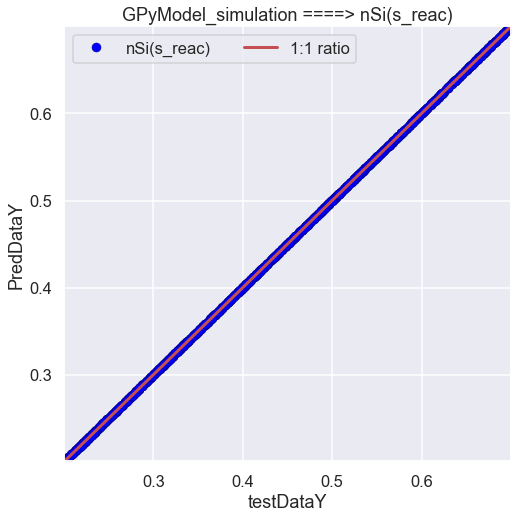

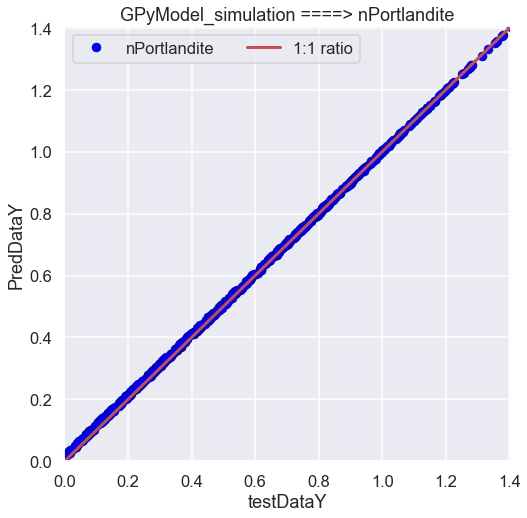

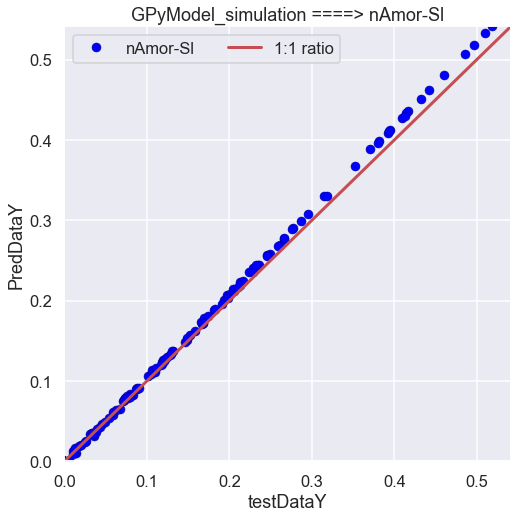

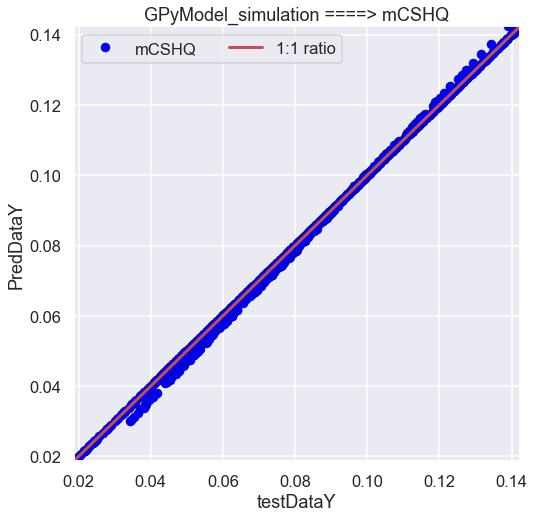

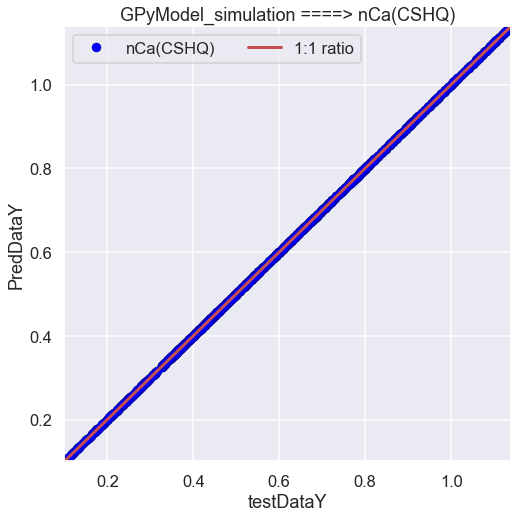

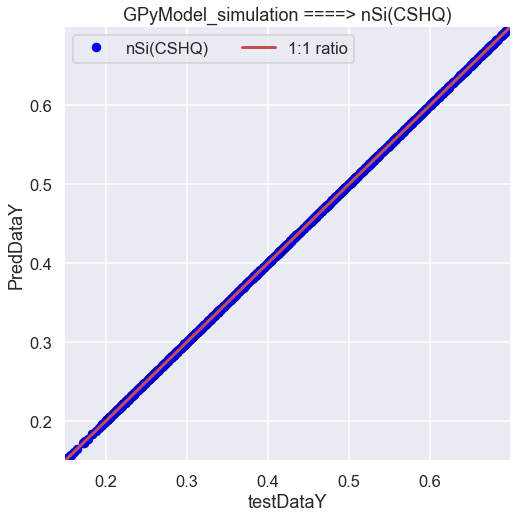

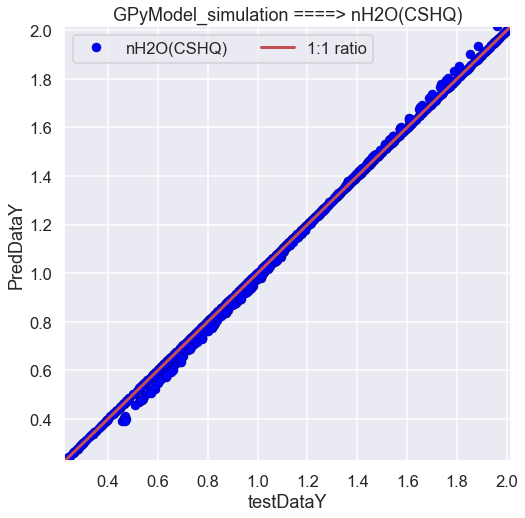

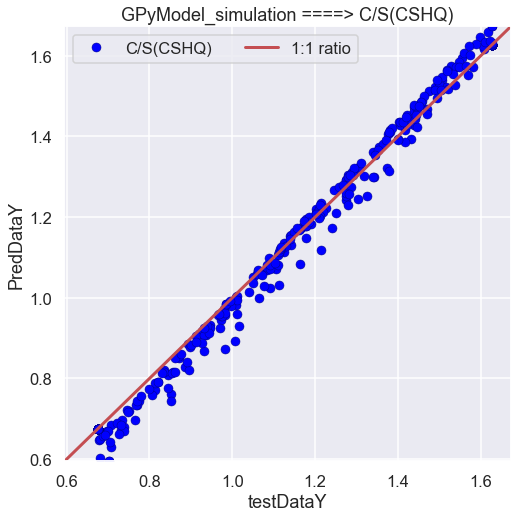

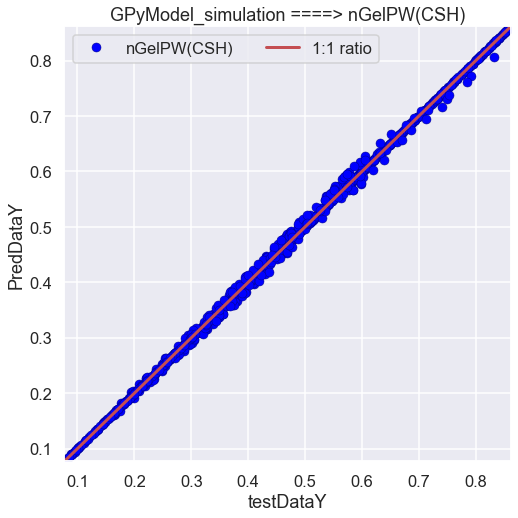

In [20]:
modelSimulations = finalDF['modelSimulation'].unique()
trgVars = finalDF['var'].unique()
statMeasure = []
for simulation in modelSimulations:
    if 'MLP' in simulation or 'xgb' in simulation: # skip the xgb and MLP models
        continue
    tempDF = finalDF[finalDF['modelSimulation']==simulation]
    for trgVar in trgVars:
        df = tempDF[tempDF['var']==trgVar]  # no Portlandite
        testDataY = df['testDataY'].values
        predDataY = df['predDataY'].values
        R2,RMSE = drawPlots(trgVar,testDataY,predDataY,simulation)
        statMeasure.append([trgVar,R2,RMSE,simulation])
    
statMeasDF = pd.DataFrame(statMeasure,columns=['Var','R2','RMSE','modelSimulation'])    


In [21]:
statMeasDF

Var        R2          RMSE      modelSimulation
0        Vol(aq)  0.998364  1.534534e-06   rfModel_simulation
1             pH  0.995538  3.498165e-03   rfModel_simulation
2        nCa(aq)  0.991041  4.855981e-09   rfModel_simulation
3         nCa(s)  1.000000  1.422999e-08   rfModel_simulation
4        nSi(aq)  0.995710  6.462783e-11   rfModel_simulation
5    nSi(s_reac)  1.000000  1.728919e-10   rfModel_simulation
6   nPortlandite  0.999267  1.052575e-04   rfModel_simulation
7       nAmor-Sl  0.995954  2.168905e-05   rfModel_simulation
8          mCSHQ  0.999046  8.272940e-07   rfModel_simulation
9      nCa(CSHQ)  1.000000  2.430480e-08   rfModel_simulation
10     nSi(CSHQ)  1.000000  1.728919e-10   rfModel_simulation
11    nH2O(CSHQ)  0.998530  2.683289e-04   rfModel_simulation
12     C/S(CSHQ)  0.996299  4.683948e-04   rfModel_simulation
13   nGelPW(CSH)  0.999045  3.410277e-05   rfModel_simulation
14       Vol(aq)  0.998766  1.157359e-06  lgbModel_simulation
15            pH  0.993213  5.321128e-03  lgbModel_simulation
16       nCa(aq)  0.993834  3.342154e-09  lgbModel_simulation
17        nCa(s)  1.000000  1.422999e-08  lgbModel_simulation
18       nSi(aq)  0.989582  1.569245e-10  lgbModel_simulation
19   nSi(s_reac)  1.000000  1.728919e-10  lgbModel_simulation
20  nPortlandite  0.999294  1.013545e-04  lgbModel_simulation
21      nAmor-Sl  0.995313  2.512609e-05  lgbModel_simulation
22         mCSHQ  0.998979  8.853396e-07  lgbModel_simulation
23     nCa(CSHQ)  1.000000  2.430480e-08  lgbModel_simulation
24     nSi(CSHQ)  1.000000  1.728919e-10  lgbModel_simulation
25    nH2O(CSHQ)  0.998574  2.602944e-04  lgbModel_simulation
26     C/S(CSHQ)  0.996383  4.578282e-04  lgbModel_simulation
27   nGelPW(CSH)  0.999045  3.410277e-05  lgbModel_simulation
28       Vol(aq)  0.998013  1.863259e-06   gbModel_simulation
29            pH  0.993931  4.758302e-03   gbModel_simulation
30       nCa(aq)  0.992966  3.812328e-09   gbModel_simulation
31        nCa(s)  1.000000  1.422999e-08   gbModel_simulation
32       nSi(aq)  0.993558  9.702912e-11   gbModel_simulation
33   nSi(s_reac)  1.000000  1.728919e-10   gbModel_simulation
34  nPortlandite  0.998131  2.683523e-04   gbModel_simulation
35      nAmor-Sl  0.991541  4.534754e-05   gbModel_simulation
36         mCSHQ  0.998975  8.883405e-07   gbModel_simulation
37     nCa(CSHQ)  1.000000  2.430480e-08   gbModel_simulation
38     nSi(CSHQ)  1.000000  1.728919e-10   gbModel_simulation
39    nH2O(CSHQ)  0.998625  2.509422e-04   gbModel_simulation
40     C/S(CSHQ)  0.994647  6.774855e-04   gbModel_simulation
41   nGelPW(CSH)  0.999045  3.410277e-05   gbModel_simulation
42       Vol(aq)  0.999379  5.827343e-07  GPyModel_simulation
43            pH  0.969998  2.352260e-02  GPyModel_simulation
44       nCa(aq)  0.997932  1.120916e-09  GPyModel_simulation
45        nCa(s)  1.000000  1.422999e-08  GPyModel_simulation
46       nSi(aq)  0.980285  2.969655e-10  GPyModel_simulation
47   nSi(s_reac)  1.000000  1.728919e-10  GPyModel_simulation
48  nPortlandite  0.999621  5.439912e-05  GPyModel_simulation
49      nAmor-Sl  0.998037  1.052214e-05  GPyModel_simulation
50         mCSHQ  0.998892  9.601329e-07  GPyModel_simulation
51     nCa(CSHQ)  1.000000  2.430480e-08  GPyModel_simulation
52     nSi(CSHQ)  1.000000  1.728919e-10  GPyModel_simulation
53    nH2O(CSHQ)  0.998662  2.442120e-04  GPyModel_simulation
54     C/S(CSHQ)  0.997455  3.221126e-04  GPyModel_simulation
55   nGelPW(CSH)  0.999045  3.410277e-05  GPyModel_simulation

In [22]:
statMeasDF_pivot=statMeasDF.pivot(index='Var',values=['R2','RMSE'],columns='modelSimulation')
statMeasDF.to_csv('statMeasure_trainDataset_noPivot.csv',index = False)

statMeasDF_pivot.to_csv('statMeasure_trainDataset_Pivot.csv')

In [23]:
## alternative way to draw figures

In [24]:
def drawCombiningPlots(plotDataDF,trgVar):
    
    fig, ax =plt.subplots(figsize=(10,10))
    
    marker = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
    colors = ['tab:blue','tab:orange','tab:gray','tab:olive','tab:cyan','tab:green']
    ## Fitting the line           
    axisMin=1000
    axisMax =-1000
    for i, col in enumerate(plotDataDF.columns[1:]):
        testDataY = plotDataDF.iloc[:,0].values
        predDataY = plotDataDF[col].values
        axMax = max(max(testDataY),max(predDataY))
        axMin = min(min(testDataY),min(predDataY))
        axisMin = min(axisMin,axMin)
        axisMax = max(axisMax,axMax)
        ax.scatter(testDataY,predDataY,marker =marker[i],edgecolor =colors[i],label=col.replace('_simulation',''))

    x2= np.linspace(axisMin,axisMax,30);
    y2 = x2
    ax.plot(x2,y2,'r-',lw=3,label ='1:1 ratio')
    ax.legend (loc='best',ncol=3)           
    ax.set_xlim(axisMin,axisMax)
    ax.set_ylim(axisMin,axisMax)
    ax.set_title(trgVar)
    ax.set_xlabel('testDataY')
    ax.set_ylabel('PredDataY')    
        


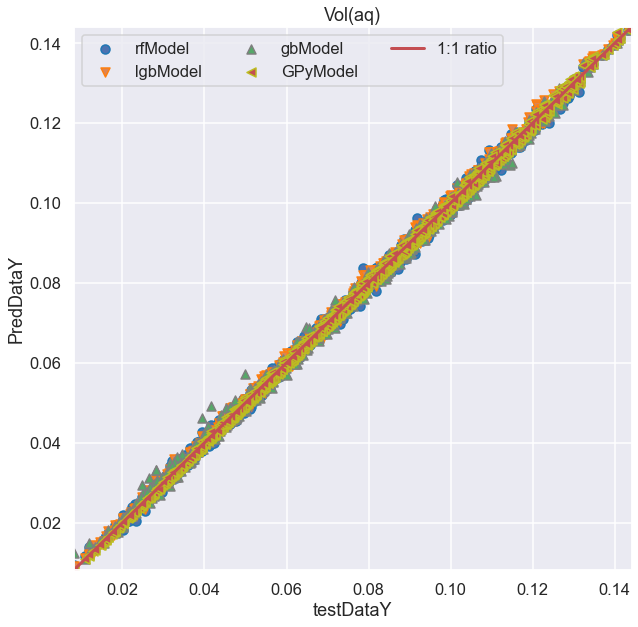

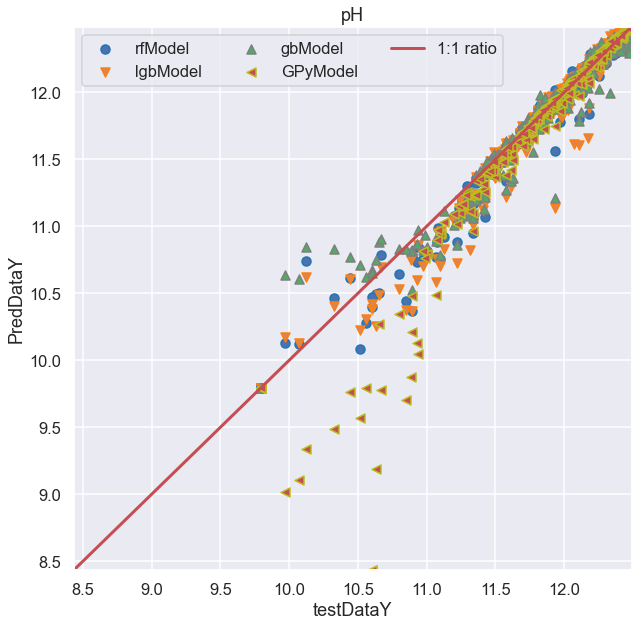

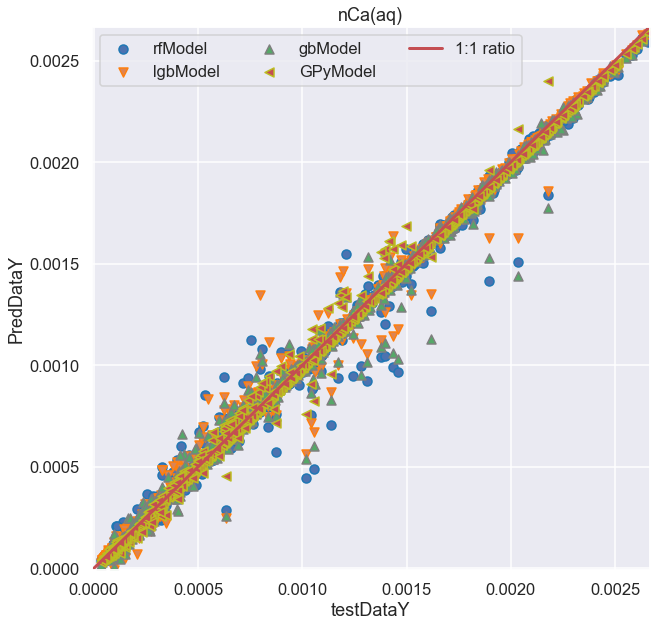

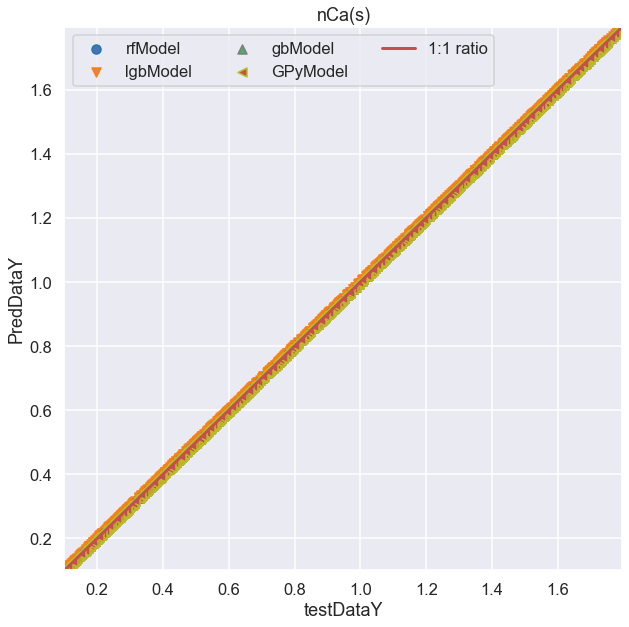

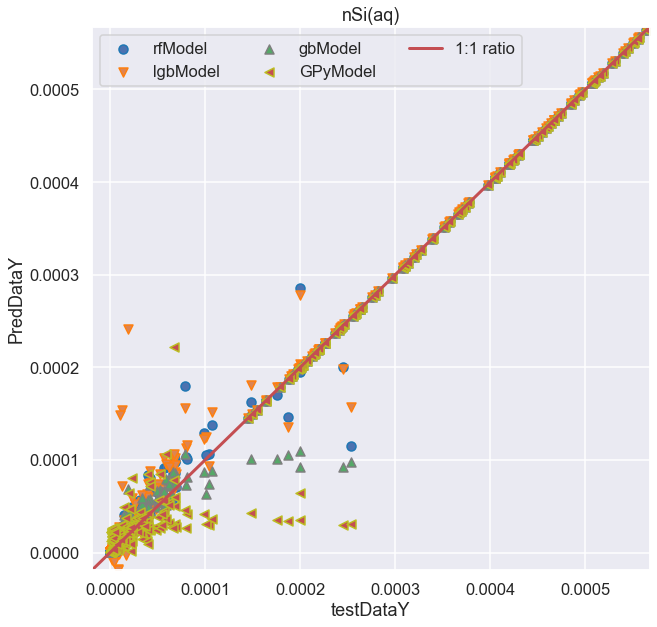

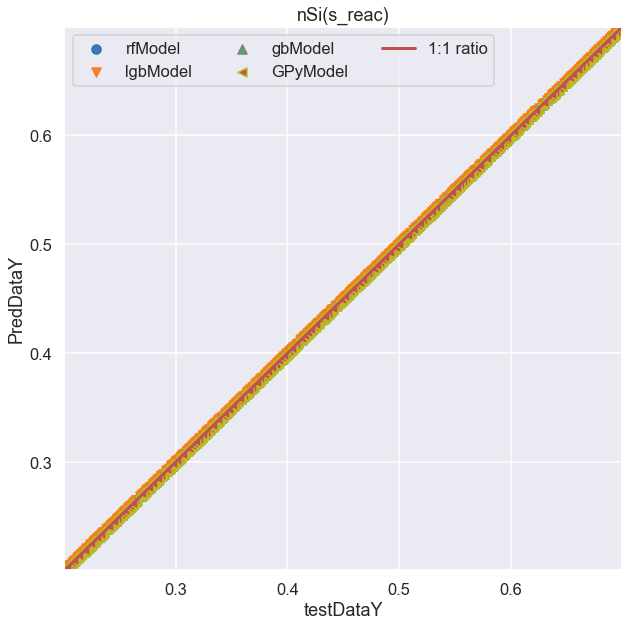

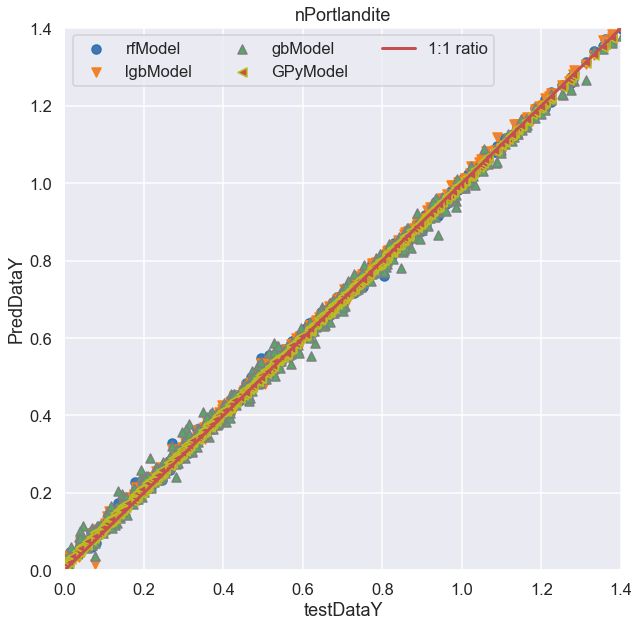

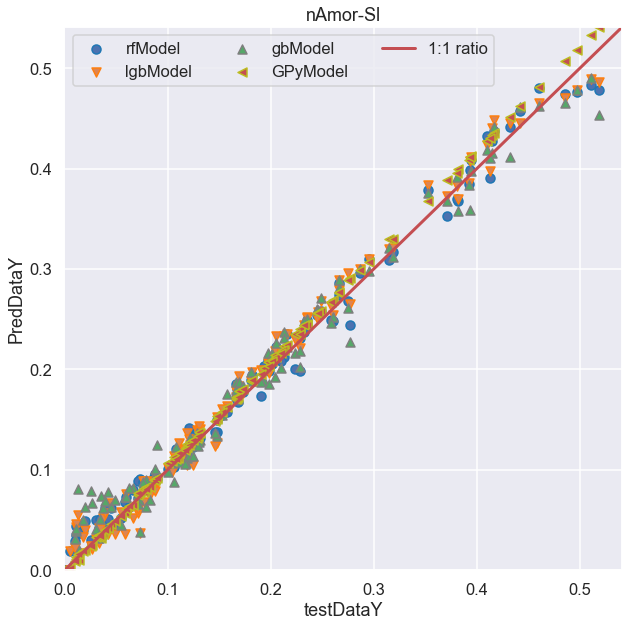

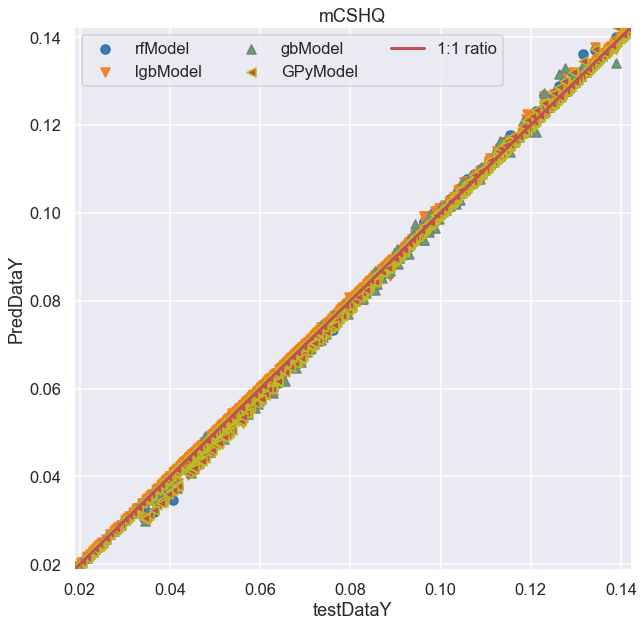

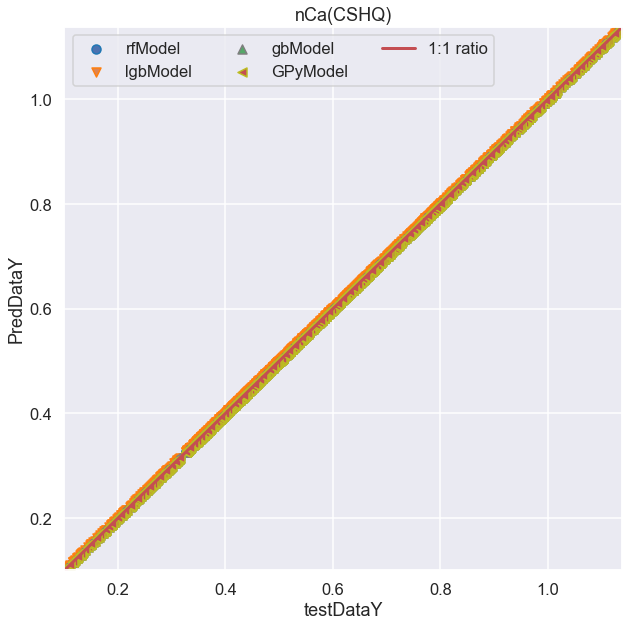

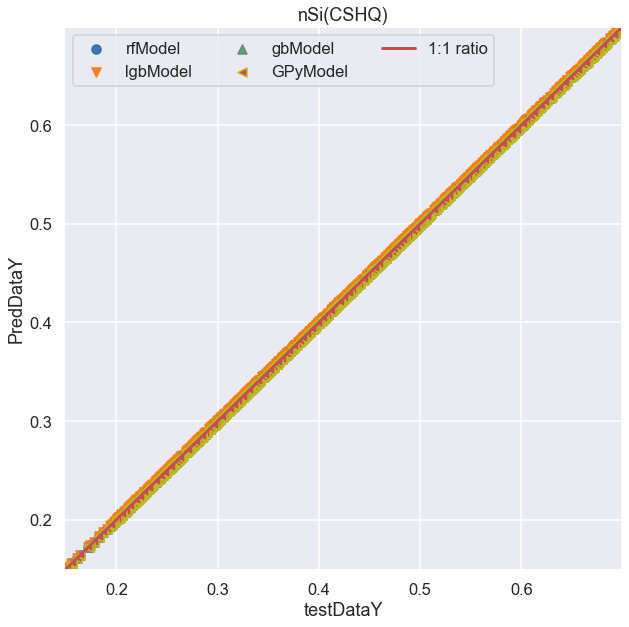

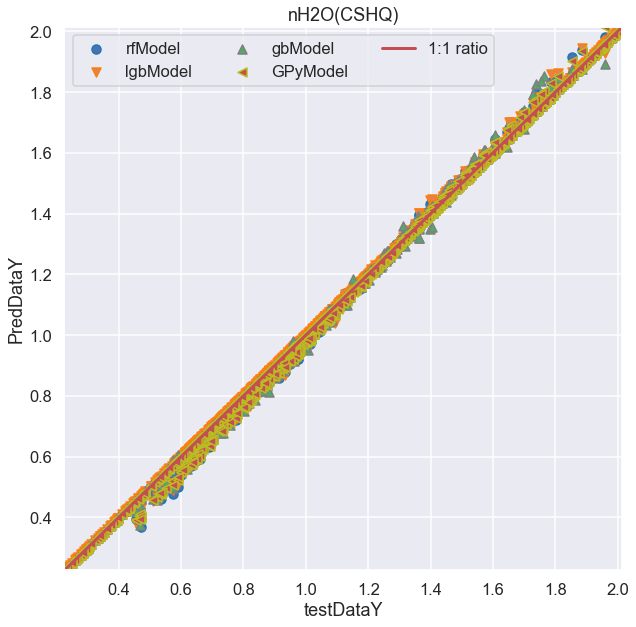

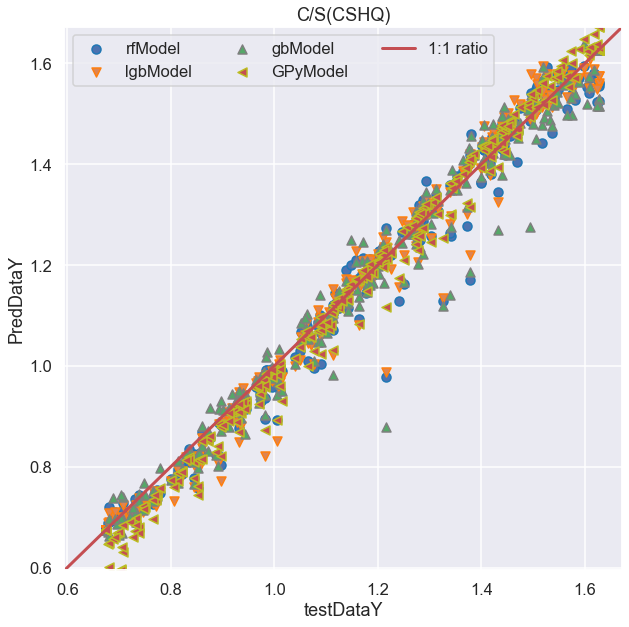

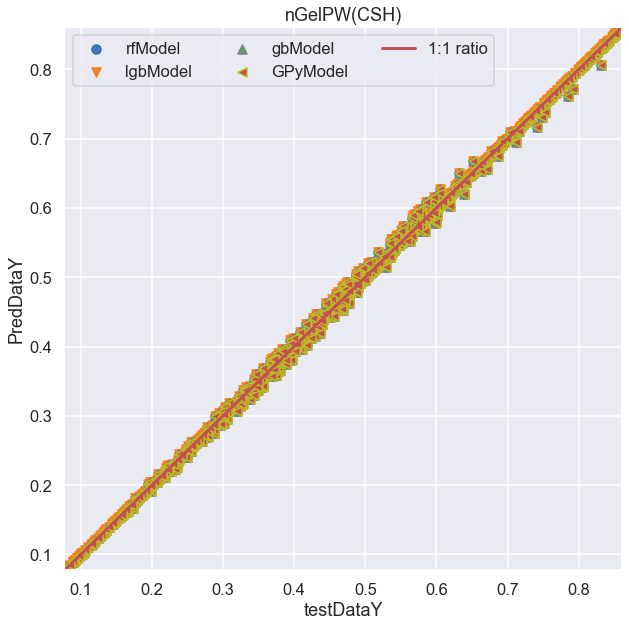

In [25]:
modelSimulations = finalDF['modelSimulation'].unique()
trgVars = finalDF['var'].unique()
for trgVar in trgVars:
    tempdf = finalDF[finalDF['var']==trgVar]  # no Portlandite
    dataplot = {}
    plotDataDF = pd.DataFrame()
    for simulation in modelSimulations:
        # skip the xgb and MLP models
        # the two models are very bad, need to be fine tune
        if 'MLP' in simulation or 'xgb' in simulation: 
            continue

        df = tempdf[tempdf['modelSimulation']==simulation]
        if len(plotDataDF)==0:
            plotDataDF=df[['testDataY','predDataY']]
        else:    
            plotDataDF = pd.concat([plotDataDF,df[['predDataY']]],axis=1)

        plotDataDF.rename({'predDataY': simulation}, axis=1,inplace=True)
                                    
    drawCombiningPlots(plotDataDF,trgVar)    
 
